In [1]:
%cd /Users/typhaine/Documents/Doc Gorilla/WhereIsMyMNIST/notebooks

/Users/typhaine/Documents/Doc Gorilla/WhereIsMyMNIST/notebooks


In [2]:
import os
import imageio
import random
from psychopy import visual, core, event, gui, data
import MotionClouds as mc
import pygame
from PIL import Image

pygame 2.0.1 (SDL 2.0.14, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import sys
sys.path.append("../figures")

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST, MotionCloudNoise

from main import init
args = init(filename='../data/2019-06-12') # pas de drop out!
args


{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-12',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [4]:
def background_noise(sf_0=0.125, B_sf=3., alpha=.1, N_pic=28, seed=42):
    mc.N_X, mc.N_Y, mc.N_frame = 60, 256/2,256/2
    fx, fy, ft = mc.get_grids(60, mc.N_Y, mc.N_frame)
    env = envelope = mc.envelope_gabor(fx, fy, ft,
    V_X=1., V_Y=0., B_V=.1,
    sf_0=.25, B_sf=.1,
    theta=0., B_theta=np.pi/8, alpha=1.)
    env = mc.random_cloud(env)
    return env

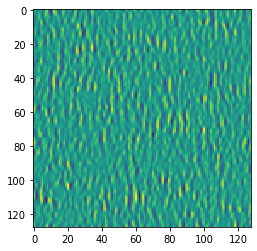

In [5]:
movie = background_noise()
plt.imshow(movie[1])

In [8]:
## Unit tests

i_offset = 1
j_offset = 1

transform=transforms.Compose([
                               WhatShift(args,i_offset=i_offset, j_offset=j_offset),
                               WhatBackground(contrast = args.contrast,
                                              noise=0, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

data, label = next(iter(train_loader))

label.shape

i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+ str(label[i].item()))
plt.show()
h = plt.hist(data[i,:,:].detach().numpy().flatten(), 30)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [12]:
temp = np.empty((60,128,128))
test = data[0].reshape(28,28)
test[test<=0.49803922] = 0

test = np.pad(test,(0,100) , 'constant', constant_values=(0))

test = np.interp(test, (test.min(), test.max()), (-1, +1))


In [13]:
test3 = data[3].reshape(28,28)
test3[test3<=0.49803922] = 0


test3 = np.pad(test3,(100,0) , 'constant', constant_values=(0))
test3 = np.interp(test3, (test3.min(), test3.max()), (-1, +1))
print(test3.shape)

(128, 128)


In [20]:
for i in range(len(test3)):
    print(test3[i])

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. 

In [17]:
movie[1].dtype

dtype('float64')

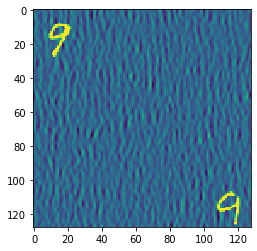

In [16]:
temp2 = np.empty((128,128))
for i in range(0,59,1):
    test2 = np.interp(movie[i], (movie[i].min(), movie[i].max()), (-1, +1))
    test4 = np.max((test*2, test2, test3*2), axis=0)
    temp2 = np.vstack((temp2,test4))
    

plt.imshow(test4)
temp2.shape
temp2 = temp2.reshape(60,128,128)
#np.linalg.norm(movie[1])

In [7]:
temp = test2
temp2 = np.empty((128,128))
np.vstack((temp2,temp))
for i in range(0,59,1):
    temp = np.roll(temp, (10+i,10+i), axis=1)
    background = np.max((test, temp, test3), axis=0)
    temp2 = np.vstack((temp2,background))


NameError: name 'test2' is not defined

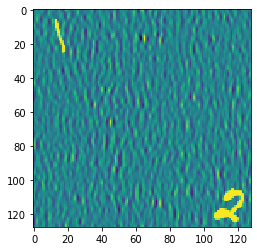

In [224]:
temp2 = temp2.reshape(60,128,128)
plt.imshow(temp2[1])

In [238]:
instructions = """
At each trial you see a series of textured images, report if you 
spot a specific digit by pressing the space bar.

Press the space bar to begin the experiment.

"""

win = visual.Window(winType = 'pyglet', size =(800,800), colorSpace = "rgb")

message = visual.TextStim(win, text= instructions)
message.autoDraw = True  # Automatically draw every frame
win.flip()
core.wait(5.0)
message.text = ''  # Change properties of existing stim
win.flip()
core.wait(0.0)

while True:
    for i in range(0,59,1):
            background = temp2[i]
            movie_clip = visual.ImageStim(win, background, colorSpace = "rgb", contrast = 1, size = 2, flipVert=True)
            movie_clip.draw()
            win.flip()


KeyboardInterrupt: 

In [227]:
data_map = data.numpy().flatten()
RGBA_temp = list()

for val in range(len(data_map)):
    if data_map[val] <= 0.49803922:
        RGBA_temp.append([0,0,0,0])
    else:
        RGBA_temp.append([255,255,255,255])

data_map = np.array(RGBA_temp, dtype = "uint8").reshape(100,28,28,4)

In [228]:
def random_number(data,number):
    random_list = list()
    for i in range(0,number,1):
        random_image = data[random.randint(0, (len(data)-1))]
        random_image = list(random_image)
        random_list.append(random_image)
    return np.array(random_list)                

def random_position(number):
    random_list = list()
    for i in range(0,number*2,1):
        random_list.append(np.random.uniform(-1,1)*0.8) # 0.8 keeps the whole number whoing on the screen
    return np.array(random_list)

def draw_image(image_data, image_position1, image_position2):
    create_image = visual.ImageStim(win, image_data, size= 0.5, pos = (image_position1, image_position2))
    return create_image.draw()

In [229]:
rand_pos = random_position(number = 10)
rand_img = random_number(data = data_map,number = 10)
number_of_images = random.randint(1,10)
for create in range(0,number_of_images,1):
    #print(rand_img[create])
    print(rand_pos[create])


-0.7214145669425632
-0.0684560794159367
-0.07322636834867317
-0.4237522894917202
0.7276101016301869
0.06706819555179884
-0.08507498570383483
-0.1818136674020046
0.24518987016867336


In [230]:
instructions = """
Varying amounts of numbers will be presented for one second. 

Please keep track of changes in numbers and locations
"""

win = visual.Window(winType = 'pyglet', size = (800,800), colorSpace = "rgb")

message = visual.TextStim(win, text = instructions)
message.autoDraw = True  # Automatically draw every frame
win.flip()
core.wait(5.0)
message.text = ''  # Change properties of existing stim
win.flip()
core.wait(0.0)

while True:
    rand_pos = random_position(number = 10)
    rand_img = random_number(data = data_map,number = 10)
    number_of_images = random.randint(1,10)
    for i in range(0,60,1): # Frames start,stop,int
        background = movie[i]*100 # the 200 changes visability
        movie_clip = visual.ImageStim(win, background, colorSpace = "rgb", contrast = 1, size = 2)
        movie_clip.draw()
        for create in range(0,number_of_images,1):
            end_of_list = -1 - create
            draw_image(image_data = rand_img[create], image_position1 = rand_pos[create],
                      image_position2 = rand_pos[end_of_list])
        win.flip()


KeyboardInterrupt: 

In [ ]:
        if i == 59:
            for create in range(number_of_images): # randomly generates numbers
                
            win.flip()
        else:
            for keep in range(len(number_of_images)):
                draw_image(np.array([keep]), keep_position[keep])

            win.flip()

In [9]:
OldMin = -0.0034365657438663265
OldMax = 0.0038717407311462827
NewMin = 0
NewMax = 255
OldRange = (OldMax - OldMin)  
NewRange = (NewMax - NewMin) 

background = mc.random_cloud(envelope).flatten()
RGBA_temp = list()

for val in range(len(background)):
    OldValue = background[val]
    NewValue = int((((OldValue - OldMin) * NewRange) / OldRange) + NewMin)
    RGBA_temp.append([NewValue,NewValue,NewValue,255])

background = np.array(RGBA_temp, dtype = "uint8").reshape(256,256,256,4)

In [ ]:
def create_numbers(data, amount_of_numbers, frame, size_of_number):
    d = {}
    for index in range(amount_of_numbers):
        image = data[random.randint(0, 99)]
        d["image{0}".format(x)] = visual.ImageStim(win, image, size=size_of_number, 
                                                   pos = (ran_num(index), 
                                                          ran_num(index))
    return create_image.draw()
    

In [ ]:
instructions = """
At each trial you see a series of textured images, report if you 
spot a specific digit by pressing the space bar.

Press the space bar to begin the experiment.

"""

win = visual.Window(winType = 'pyglet', size =(800,800), colorSpace = "rgb")

message = visual.TextStim(win, text= instructions)
message.autoDraw = True  # Automatically draw every frame
win.flip()
core.wait(5.0)
message.text = ''  # Change properties of existing stim
win.flip()
core.wait(0.0)

create_numbers(data = data_map, amount_of_numbers = random.randint(1,10), size_of_number = 0.5)

while True:
    for i in range(0,60,1):
        background = movie[i]*200
        movie_clip = visual.ImageStim(win, background, colorSpace = "rgb", contrast = 1, size = 2)
        movie_clip.draw()
        if i == 59:
            create_numbers(data = data_map, amount_of_numbers = random.randint(1,10), size_of_number = 0.5)
            
            Image_one = data_map[random.randint(0, 99)]
            one = visual.ImageStim(win, Image_one, size=0.5)
            one.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            one.draw()

            Image_two = data_map[random.randint(0, 99)]
            two = visual.ImageStim(win, Image_two, size=0.5)
            two.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            two.draw()

            Image_three = data_map[random.randint(0, 99)]
            three = visual.ImageStim(win, Image_three, size=0.5)
            three.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            three.draw()
        
            Image_four = data_map[random.randint(0, 99)]
            four = visual.ImageStim(win, Image_four, size=0.5)
            four.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            four.draw()
            win.flip()
        else:
            one = visual.ImageStim(win, Image_one, size=0.5)
            one.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            one.draw()
            
            two = visual.ImageStim(win, Image_two, size=0.5)
            two.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            two.draw()

            three = visual.ImageStim(win, Image_three, size=0.5)
            three.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            three.draw()
            
            four = visual.ImageStim(win, Image_four, size=0.5)
            four.pos = (np.random.uniform(-1,1), np.random.uniform(-1,1))
            four.draw()
            win.flip()

